In [7]:
import os
import pathlib
import random
from itertools import product
from typing import Union, Tuple, Sequence, List

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from PIL.Image import Resampling
from numpy import ndarray
from scipy import spatial

# Setting up some global parameters
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [8]:
class ImageHandler:
    """Class to handle the image processing"""

    @staticmethod
    def display_images(img_seq: Sequence[ndarray], img_titles: List[str] = [], figsize: Tuple[int] = (10, 10)) -> None:
        """Display a sequence of images in a grid"""

        plt.Figure(figsize=figsize)
        plt.axis('off')
        for index, img in enumerate(img_seq):
            if len(img_titles) > 0:
                plt.title(img_titles[index])
            fig = plt.imshow(img)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
            plt.show()

    @staticmethod
    def save_images(img_seq: Union[Sequence[ndarray], Sequence[Image.Image]], path: Union[str, pathlib.Path],
                    prefix: str = "", suffix: str = "", extension: str = "png") -> None:
        """Save a sequence of images to a given path"""
        path = pathlib.Path(path)
        path.mkdir(parents=True, exist_ok=True)

        if prefix:
            prefix += "_"
        if suffix:
            suffix = f"_{suffix}"

        for i, img in enumerate(img_seq):
            if not isinstance(img, Image.Image):
                img = Image.fromarray(img)
            img.save(path / f"{prefix}{i}{suffix}.{extension}")

In [9]:
class MosaicMaker(ImageHandler):
    """Class to make mosaic (tile) images"""

    def __init__(self, img_width: int = 256, img_height: int = 256, jit_compile: bool = False, seed: int = None):
        self.img_width = img_width
        self.img_height = img_height
        self.jit_compile = jit_compile
        self.seed = seed
        self.model = keras_cv.models.StableDiffusion(img_width=self.img_width, img_height=self.img_height,
                                                     jit_compile=self.jit_compile)
        # Making model's behaviour (more) deterministic
        if self.seed:
            tf.random.set_seed(self.seed)

    def make_images(self, text: str, attributes: Tuple[str] = ("detailed", "painting"),
                    num_images: int = 3) -> Sequence[ndarray]:
        """Make a sequence of images from a given text and attributes using the StableDiffusion model available from Keras-CV submodule"""
        if attributes:
            text = f"{text}, {', '.join(attributes)}"
        return self.model.text_to_image(text, batch_size=num_images)

In [10]:

class MosaicArtMaker(ImageHandler):
    """Class to make a mosaic art from a given image"""

    # Inspired by https://medium.com/@aarongrove/creating-image-mosaics-with-python-8e4c25dd9bf9

    def __init__(self, original_image_path: Union[str, pathlib.Path], tile_images_dir: str = "images/tiles",
                 sqrt_num_tiles: int = 4, tile_file_extension: str = "png"):

        # Load the original image and get its metadata
        self.original_image_path = pathlib.Path(original_image_path)
        self.original_image_name = original_image_path.parts[-1].split(".")[0]
        self.original_image = Image.open(original_image_path)
        self.original_image_width, self.original_image_height = self.original_image.size

        # Check if the original image is a square image
        assert self.original_image_width == self.original_image_height, "Image must be square"

        # Load the tile images and use the mean of the RGB values as the metadata for indexing
        self.sqrt_num_tiles = sqrt_num_tiles
        self.tile_size = self.original_image_width // self.sqrt_num_tiles
        self.grid = list(
            product(range(0, self.original_image_width - (self.original_image_width % self.tile_size), self.tile_size),
                    range(0, self.original_image_height - (self.original_image_height % self.tile_size),
                          self.tile_size)))

        self.tile_images_dir = pathlib.Path(tile_images_dir)
        self.tile_images = []
        for tile_image_path in self.tile_images_dir.glob(f"*.{tile_file_extension}"):
            img = Image.open(tile_image_path)
            img_metadata = []
            for i in range(3):
                img_metadata.append(np.mean(np.array(img)[:, :, i]))
            self.tile_images.append((img, tuple(img_metadata)))

        # Check if the tile images are loaded successfully
        assert self.tile_images, "No tile images found"

        # Creating a KDTree index to find similar tiles to the parts of the original image
        self.index = spatial.KDTree([x[1] for x in self.tile_images])

    def make_mosaic_art(self, k: int = 10, seed: Union[int, None] = None) -> Image.Image:
        """Make a mosaic art from the original image using the tile images created by the SableDiffusion model"""

        # Setting the seed for reproducibility if it is given
        if seed is not None:
            random.seed = seed

        # Making a mosaic art by replacing the parts of the original image with similar tiles from the tile images
        output_image = Image.new('RGB', (self.original_image_width, self.original_image_height))
        for i, j in self.grid:
            box = (j, i, j + self.tile_size, i + self.tile_size)
            original_piece = self.original_image.crop(box)
            original_piece_metadata = []

            # Getting the mean of the RGB values of the original piece to find similar tiles
            for i in range(3):
                original_piece_metadata.append(np.mean(np.array(original_piece)[:, :, i]))

            # Finding the k nearest neighbours of the original piece in the tile images and randomly choosing one
            # So that we can make the mosaic art more interesting by avoiding repetition
            similar_tiles_indices = self.index.query(original_piece_metadata, k=k)[1]

            tile_image = self.tile_images[random.choice(similar_tiles_indices)][0]

            # Resizing the tile image so that it can be pasted on the original image
            tile_image = tile_image.resize((self.tile_size, self.tile_size), Resampling.NEAREST)
            output_image.paste(tile_image, box)
        return output_image

In [11]:
def main(remake_tiles: bool) -> None:
    """Main function to pack everything together and run it"""

    # Extension to use for saving and loading the tile images
    tile_file_extension = "jpeg"

    # (Re)-make the tile images if the user wants to do so
    if remake_tiles:

        # Create a MosaicMaker object to make the tile images
        image_maker = MosaicMaker(img_width=400, img_height=400, jit_compile=False, seed=33)

        # The text prompts to be used to make the tile images
        prompt_seq = (("A laughing woman", ("realistic", "white background")),
                      ("A sad girl", ("realistic", "white background")),
                      ("An old man", ("realistic", "white background")),
                      ("Face of a sad man", ("realistic", "white background")),
                      ("Drawing of rings of Saturn", ("abstract", "white background")),
                      ("A water color paining of a puppy", ("detailed",)),
                      ("Drawing of a red rose", ("elegant", "detailed", "white background")),
                      ("View of a green forest with mountains in the the background", ("elegant", "lush", "nature")),
                      ("A painting of four oranges in a bowl", ("elegant", "detailed", "white background")),
                      ("A ninja shuriken", ("realistic", "metal", "white background")),)

        # Make the tile images and save them
        for index, prompt_data in enumerate(prompt_seq):
            image_seq = image_maker.make_images(prompt_data[0], prompt_data[1], num_images=40)
            image_maker.save_images(img_seq=image_seq, path='images/tiles', prefix=f'p{index}',
                                    extension=tile_file_extension)

    # Use the images in the images/canvases and images/tiles directories to make mosaic arts
    mosaic_images = []
    mosaic_images_titles = []
    for canvas_image_path in pathlib.Path("images/canvases").glob("*.png"):
        # Create a MosaicArtMaker object
        art_maker = MosaicArtMaker(original_image_path=canvas_image_path, sqrt_num_tiles=200,
                                   tile_file_extension=tile_file_extension)

        # Make the mosaic art and save it in the images/outputs directory
        output_image = art_maker.make_mosaic_art(k=40)
        art_maker.save_images((output_image,), path='images/outputs',
                              prefix=f'{art_maker.original_image_name}_mosaic_art')

        mosaic_images.append(art_maker.original_image)
        mosaic_images.append(output_image)
        mosaic_images_titles.append(art_maker.original_image_name)
        mosaic_images_titles.append(art_maker.original_image_name + "_mosaic_art")

    # Display each original image and its mosaic art version
    art_maker.display_images(mosaic_images, mosaic_images_titles)

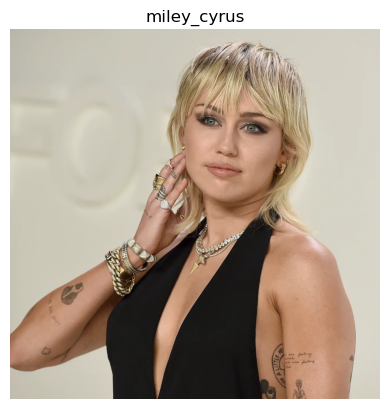

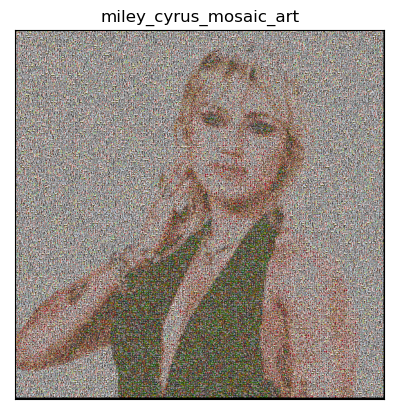

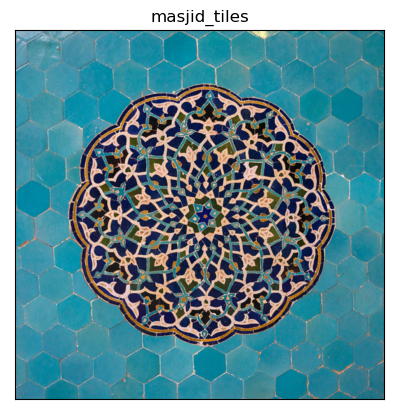

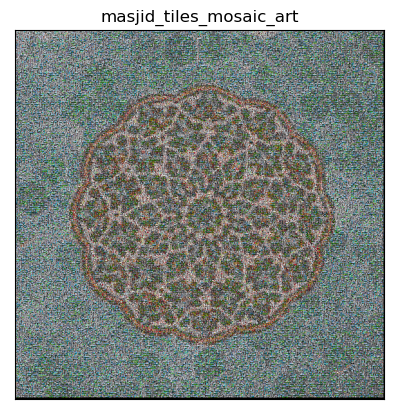

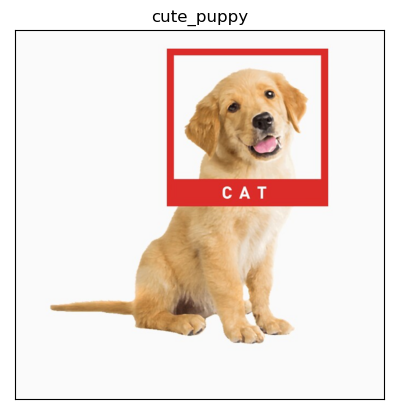

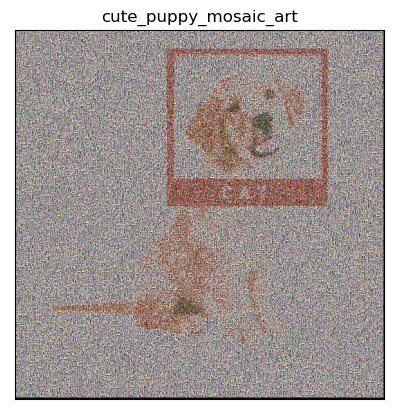

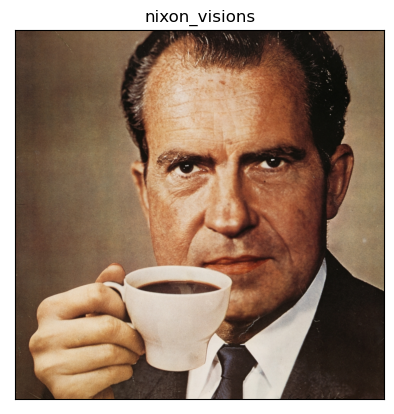

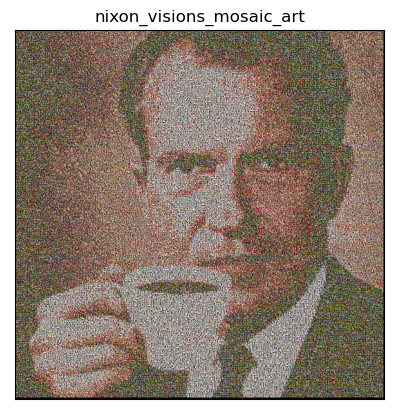

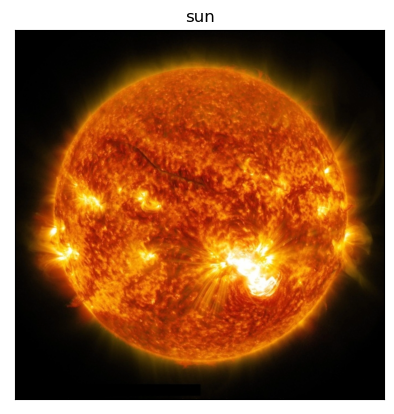

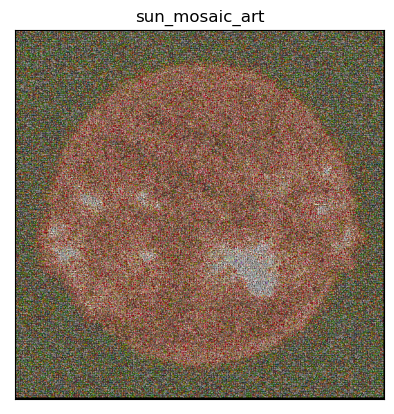

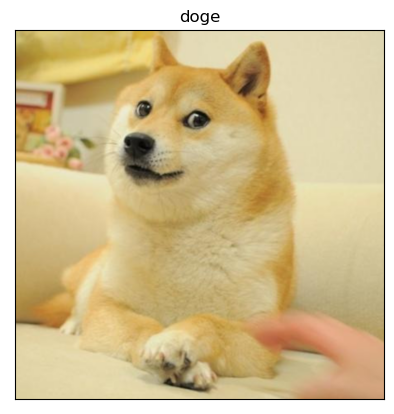

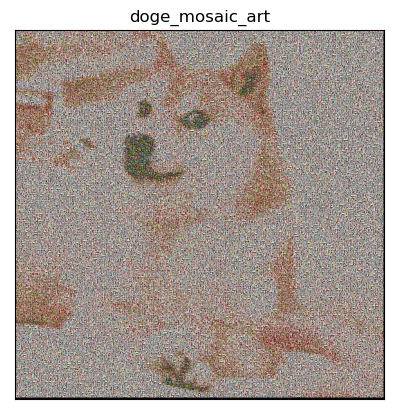

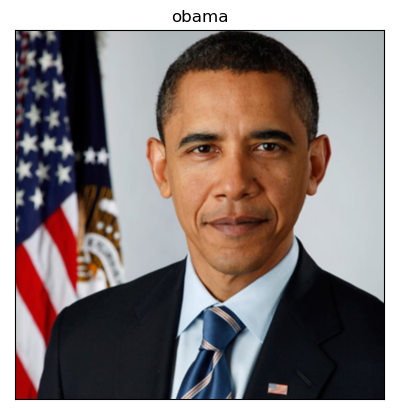

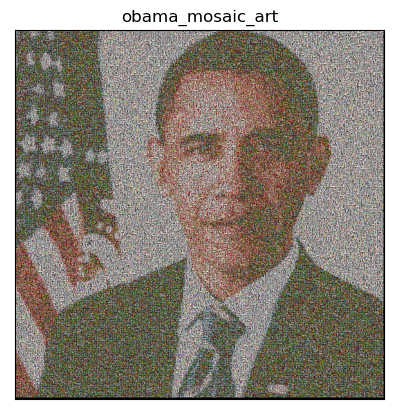

In [12]:
# If remake_tiles is set to 'True', the tile images will be remade and the mosaic arts will be made from the new tiles
# It takes a while to make the tile images, so it is recommended to set it to 'False' after the first run
main(remake_tiles=False)